# Problem

The City of Gotham is looking at putting in new cell phone towers. Some possible locations of the cell phone towershave been identified. To avoid overheads Gotham should only purchase the required number of cell phone towers such that 
1. the cell phone tower signal ranges do not overlap
2. as much of Gotham City can be within cell signal range

This problem can be mapped to a UD-MIS problem. In that case each potential location corresponds to a vertice and can hold a tower, which corresponds to being activated or not. Constraint 1 trasnlates into the disk constraint, which define the edges of the graph. Constraint 2 corresponds to the fact that a maximum of tower shall be installed which translates into optimisation of the cardinality of independent set.

We solve the problem with the simulated classical annealing and the brute force solver. The problem is not complex enough for the simulated annealing to beat the brute force implementation in runtime (3s vs 0.2s). The brute force solver outputs a set of possible solutions :
![Task 3: Result](./img/Task3_Gotham.png)

# Initialisation

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from abstract_udmis import AbstractUDMIS

In [3]:
import time

In [5]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)
        print(self.num_vertices)
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
    
    def find_edges(self):
        #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges[i,j] = True
                    edges[j,i] = True
                    
        return edges
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices)        
    
    def draw_graph(self,occupations = None):
        
        # inner function
        def draw_circles(ax,xs,ys,cs):

            # plot the non activated vertices in the background
            for x,y,c in zip(xs,ys,cs):
                if not(c):
                    circle = plt.Circle((x,y),0.5,color = 'gray',alpha=0.5 )
                    ax.add_patch(circle)

            # plot the activated vertices in the foreground        
            for x,y,c in zip(xs,ys,cs):
                if c:
                    circle = plt.Circle((x,y),0.5,color = 'b',alpha=0.3)
                    ax.add_patch(circle)
        
        #core of function
        graph_np = np.array(self.graph)
        xs = graph_np[:,0]
        ys = graph_np[:,1]
        
        if occupations==None:
            cs = self.occupations
            fig, ax = plt.subplots()
            draw_circles(ax,xs,ys,cs)
            ax.axis('equal')
        else:
            N = min(5,len(occupations))
            fig, axs = plt.subplots(1,N,figsize=(20,4))
            for i in range(N):
                cs = occupations[i]
                draw_circles(axs[i],xs,ys,cs)
                axs[i].axis('equal')
        
        return fig
        
    def brute_force(self):
        numVertice = self.num_vertices
        format_string = '0' + str(numVertice) + 'b'
        bitlist = []
        for n in range(2**numVertice):
            bitlist.append([int(x) for x in format(n, format_string)])
        A = np.array(bitlist)
        I,J = np.where(np.triu(self.edges))
        edge = np.zeros(2**numVertice)
        for i,j in zip(I,J):
            edge += A[:,i]*A[:,j]
        cost = np.sum(A,axis=1)*1.0 - edge * numVertice
        energy = np.max(cost)
        solutions = A[cost==energy,:]
        occupations = (solutions == 1).tolist()
        return energy,occupations

# Gotham Graph

In [6]:
u = 1.35
graph = [(1.19, 4.25),
        (2.71, 3.48),
        (1.19, 3.51),
        (2, 3.38),
        (1.12, 2.86),
        (1.70, 2.42),
        (2.36, 2.54),
        (1.52, 1.48),
        (2.15, 1.54),
        (2.14, 1.87),
        (1.72, 0.86),
        (2.29, 0.87)]

udmis = UDMIS(u, graph)

12


### classical annealing

In [9]:
tic = time.time()
N = 5000
t = np.arange(N+1)
T_i = 100
T_f = 0.01

T = T_i * ((T_f/T_i) ** (t/N))

for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T[t]
    E = udmis.mc_step(T=temp)

toc = time.time()

print(-E)
# print(udmis.occupations)
print(f"computation took {toc-tic:2f} seconds")

5.0
computation took 3.139140 seconds


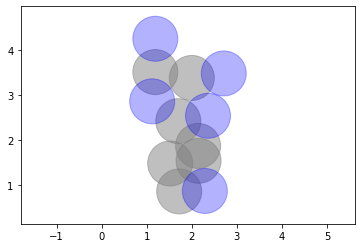

In [10]:
udmis.draw_graph();

### brute force

In [11]:
tic = time.time()
E, occupations = udmis.brute_force()
toc = time.time()

print(E)
# print(occupations)
print(f"computation took {toc-tic:2f} seconds")

5.0
computation took 0.023976 seconds


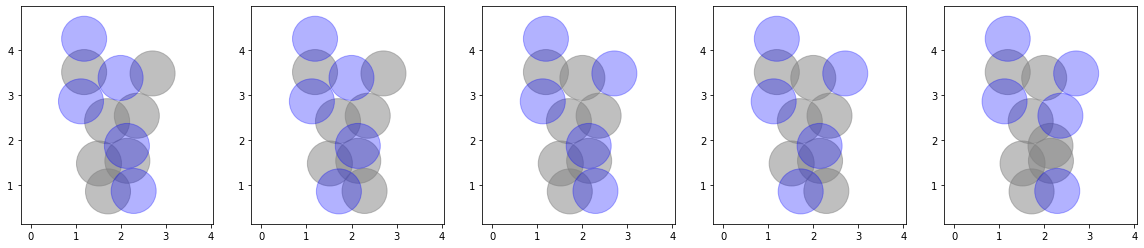

In [12]:
fig = udmis.draw_graph(occupations = occupations);

# New formulation

New problem : 
maximise surface covered = number of towers - overlap while minimising the overlap  surface
The new Hamiltonian can be expressed as this, and varying the u parameter will change the balance between the two objectives.

$$
H = -\sum_{i \in V} n_i + u \sum_{i,j \in E} w_{ij} n_i n_j
$$
where 
$$
d = dist(i,j)
$$
$$
w_{ij} = overlap(i,j) = \frac{2}{\pi} (arcos(d) - d  \sqrt{1-d^2})
$$

In [153]:
class GraphWeighted():
    def __init__(self,graph):
        self.graph = graph
        self.num_vertices = len(self.graph)
        print(self.num_vertices)
        self.edges = self.find_edges()
    
    def find_edges(self):
        G = np.array(graph)
        D = np.sqrt(np.square(G[:,0:1]-np.transpose(G[:,0:1])) + np.square(G[:,1:2]-np.transpose(G[:,1:2])))
        D = D*(D<1)*(D!=0)  
        S = (np.arccos(D)-D*np.sqrt(1-D**2)*2)/np.pi # exact overlap function
#         S = 1-D #simplified    
        return edges
              
    def brute_force(self):
        numVertice = self.num_vertices
        format_string = '0' + str(numVertice) + 'b'
        bitlist = []
        for n in range(2**numVertice):
            bitlist.append([int(x) for x in format(n, format_string)])
        A = np.array(bitlist)
        
        # calculate overlap for each config
        I,J = np.where(np.triu(self.edges))
        overlap = np.zeros(2**numVertice)
        for i,j in zip(I,J):
            overlap += A[:,i]*A[:,j]*self.edges[i,j]
        
        # number of towers turned on
        cost = np.sum(A,axis=1)*1.0
        
        plt.scatter(cost,overlap)
        
        inds = np.zeros(self.num_vertices+1,dtype=int)
        for c in np.arange(self.num_vertices+1):
            overlap_bis = overlap.copy()
            overlap_bis[cost!=c] = self.num_vertices
            inds[c] = int(np.argmin(overlap_bis))
            
        occupations = (A[inds,:]).tolist()
        
        overlaps = overlap[inds]
        plt.plot(np.arange(self.num_vertices+1),overlaps, 'r')
        
        return occupations, overlaps
    
    def draw_graph(self,occupations = None,titles = None):
        
        # inner function
        def draw_circles(ax,xs,ys,cs):

            # plot the non activated vertices in the background
            for x,y,c in zip(xs,ys,cs):
                if not(c):
                    circle = plt.Circle((x,y),0.5,color = 'gray',alpha=0.5 )
                    ax.add_patch(circle)

            # plot the activated vertices in the foreground        
            for x,y,c in zip(xs,ys,cs):
                if c:
                    circle = plt.Circle((x,y),0.5,color = 'b',alpha=0.3)
                    ax.add_patch(circle)
        
        #core of function
        graph_np = np.array(self.graph)
        xs = graph_np[:,0]
        ys = graph_np[:,1]
        
        if occupations==None:
            cs = self.occupations
            fig, ax = plt.subplots()
            draw_circles(ax,xs,ys,cs)
            ax.axis('equal')
        else:
            N = min(5,len(occupations))
            fig, axs = plt.subplots(1,N,figsize=(20,4))
            for i in range(N):
                cs = occupations[i]
                draw_circles(axs[i],xs,ys,cs)
                axs[i].axis('equal')
                axs[i].set_title(titles[i])
        
        return fig
        

In [154]:
graph_w = GraphWeighted(graph)

12


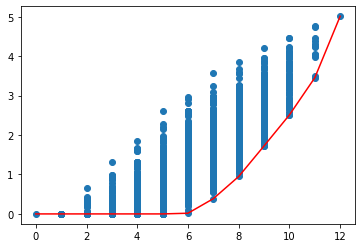

In [155]:
occupations, overlaps = graph_w.brute_force()

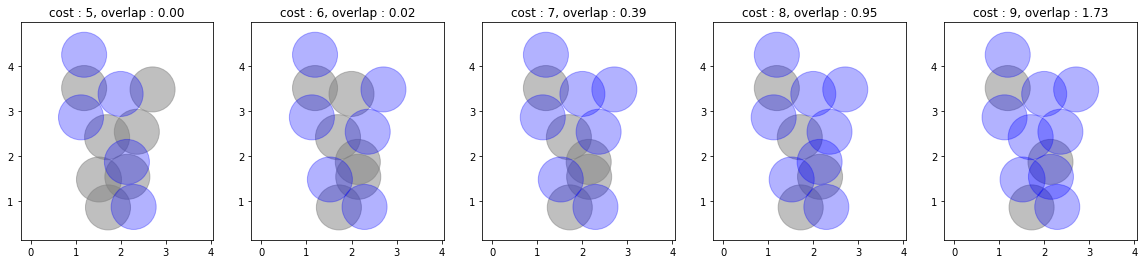

In [157]:
titles =[]
for i in range(graph_w.num_vertices):
    titles.append(f"cost : {i}, overlap : {overlaps[i]:.2f}")
graph_w.draw_graph(occupations=occupations[5:10],titles=titles[5:10]);